In [6]:
import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random as random

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.linear_model import SGDClassifier

from calibration_util import *
from kendall_errors import *
%matplotlib inline
%precision 3
import warnings
warnings.filterwarnings('ignore')

/home/caitlin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


FA*IR rankings apply post-processing methods to correct for unfairness 
according to criteria laid out in the paper.

Applies correction for a prefix of the ranking with length k
if k is larger than one of the candidate lists we have available, the ranking is filled up with
candidates from the other group, i.e. if all protected candidates already appear in the ranking
the left over positions are filled with non-protected

In [7]:
def formatRank_german(df):
    tmp = pd.DataFrame()
    tmp['y']=df.sort_values('y_pred',ascending=False).index
    tmp['y_pred']=tmp.index
    tmp['g']=df.sort_values('y_pred',ascending=False)['g']
    return tmp

In [8]:
def formatRank_compas(df):
    tmp = pd.DataFrame()
    tmp['y']=df.sort_values('y_pred').index
    tmp['y_pred']=tmp.index
    tmp['g']=df.sort_values('y_pred')['g']
    return tmp

In [9]:
def readFA_IRData(inpath, filename, funct):
    return funct(pd.read_pickle(inpath+filename))

1. The "colorblind" ranking

2. "Baseline"
We just predict the rankings according to the original scores. This lets us analyze the statistical parity of the original list. there will be no errors for equalized odds or calibration.
3. "Feldman" 
this changes the scores assigned to items - instead of just rearranging the list. The process is :
        1. take a protected candidate x
        2. determine the percentile of that candidate within their group percentile(x)
        3. find a non-protected candidate y that has the same percentile(y) == percentile(x)
        4. assign the score of y to x
        5. goto 1
        
To analyze these scores we reset "y" to be the original scores

In [10]:
def getAllFA_IRData(inpath, funct):
    d ={}

    d['cb'] = readFA_IRData(inpath, 'ColorblindRanking.pickle', funct)
    d['base'] = d['cb']
    d['feld'] = readFA_IRData(inpath, 'FeldmanRanking.pickle', funct)
    d['feld']['y'] = d['cb']['y']
    d['fair1'] = readFA_IRData(inpath, 'FairRanking01PercentProtected.pickle', funct)
    d['fair2'] = readFA_IRData(inpath, 'FairRanking02PercentProtected.pickle', funct)
    d['fair3'] = readFA_IRData(inpath, 'FairRanking03PercentProtected.pickle', funct)
    d['fair4'] = readFA_IRData(inpath, 'FairRanking04PercentProtected.pickle', funct)
    d['fair5'] = readFA_IRData(inpath, 'FairRanking05PercentProtected.pickle', funct)
    d['fair6'] = readFA_IRData(inpath, 'FairRanking06PercentProtected.pickle', funct)
    d['fair7'] = readFA_IRData(inpath, 'FairRanking07PercentProtected.pickle', funct)
    d['fair8'] = readFA_IRData(inpath, 'FairRanking08PercentProtected.pickle', funct)
    d['fair9'] = readFA_IRData(inpath, 'FairRanking09PercentProtected.pickle', funct)
    return d

In [11]:
def plot_all(data, w, s): 
    plt.figure(figsize=(12, 3,))
    plt.subplot(131) # equivalent to: plt.subplot(2, 2, 1)
    
    e0,e1 = sliding_kendall_parity(data, window=w, step=s)
    plt.plot(e0, color='red')
    plt.plot(e1, color='blue')
    plt.ylim([0,1])
    plt.title("Parity")

    plt.subplot(132) # equivalent to: plt.subplot(2, 2, 1)
    e0,e1 = sliding_kendall_cal2(data, window=w, step=s)
    plt.plot(e0, color='red')
    plt.plot(e1, color='blue')
    plt.ylim([0,1])
    plt.title("Calibration")

    plt.subplot(133) # equivalent to: plt.subplot(2, 2, 1)
    e0,e1 = sliding_kendall_eq(data, window=w, step=s)
    plt.ylim([0,1])
    plt.plot(e0, color='red')
    plt.plot(e1, color='blue')
    plt.title("Equality")
    plt.show()

    synth_errs = diagnose_k(data, w, s)
    print(synth_errs.transpose().round(2))

In [50]:
def get_all_errs(df, err, window=100, step=10):
    err0,err1 = err(df, window, step)
    errs=[]
#     r0=stats.zscore(range(len(err0)))
#     r1=stats.zscore(range(len(err1)))
    r0=[x/len(err0) for x in range(len(err0))]
    r1=[x/len(err1) for x in range(len(err1))]
    c0=stats.pearsonr(err0,r0)[0]
    
    c1=stats.pearsonr(err1,r1)[0]
#     print(c0,np.std(r0),np.std(err0))
    errs.append(stats.linregress(r0, y=err0)[0])
    errs.append(stats.linregress(r1, y=err1)[0])
#     errs.append(c0 * (np.std(r0)/np.std(err0)))
#     errs.append(c1 * (np.std(r1)/np.std(err1)))
    errs.append(stats.pearsonr(err0,err1)[0])
#     errs.append(np.linalg.norm(np.array(err0) - np.array(err1)))
    diffs = np.abs(np.array(err0) - np.array(err1))
    
    errs.append(np.sum(diffs) / len(err0))
    errs.append(stats.ttest_ind(err0,err1)[1])
    return errs

def norm(x):
    x = (x - np.mean(x))/np.std(x)
    

In [51]:
def diagnose_k(df,w, s):
     
#     dfs= run(data_g,data_y,data_X)
    
    errs=pd.DataFrame(index=[['trend0','trend1','cor','dist','sig']])
    #statistical parity
    errs['parity'] = get_all_errs(df, sliding_kendall_parity, window=w, step=s)
        
    #Calibration
    errs['cal'] = get_all_errs(df, sliding_kendall_cal2, window=w, step=s)
        
    #Equalized Odds
    errs['eq'] = get_all_errs(df, sliding_kendall_eq, window=w, step=s)
        
    return errs

In [52]:

#normalized version
# def sliding_kendall_parity(df, window, step):
#     df.sort_values('y_pred', ascending=False, inplace=True)
#     err0=[]
#     err1=[]
#     start=0
#     end=window
#     while end<len(df):
#         vals = df.iloc[range(start,end)]
#         g = np.array(vals[['y_pred', 'g']])
#         p = pairs(len(g)) - pairs(len(vals[vals['g']==1])) - pairs(len(vals[vals['g']==0]))
#         e0 = 0 if p == 0 else count_inversions(g, 0, len(g)-1, merge_parity_0)[1] / p
#         err0.append(e0)
#         e1 = 0 if p == 0 else count_inversions(g, 0, len(g)-1, merge_parity_1)[1] / p
#         err1.append(e1)
#         start+=step
#         end+=step
#     #get end of rank is needed
#     if(start > len(df)-window):
#         vals = df.iloc[range(len(df)-window,len(df))]
#         g = np.array(vals[['y_pred', 'g']])
#         p = pairs(len(g)) - pairs(len(vals[vals['g']==1])) - pairs(len(vals[vals['g']==0]))
#         e0 = 0 if p == 0 else count_inversions(g, 0, len(g)-1, merge_parity_0)[1] / p
#         err0.append(e0)
#         e1 = 0 if p == 0 else count_inversions(g, 0, len(g)-1, merge_parity_1)[1] / p
#         err1.append(e1)
#     return err0, err1

In [55]:

# #normalized version
# def sliding_count_groups(df, window, step):
#     df.sort_values('y_pred', ascending=False, inplace=True)
#     err0=[]
#     err1=[]
#     start=0
#     end=window
#     while end<len(df):
#         vals = df.iloc[range(start,end)]
#         g = np.array(vals[['y_pred', 'g']])
#         p = pairs(len(g)) - pairs(len(vals[vals['g']==1])) - pairs(len(vals[vals['g']==0]))
#         print("Num g0:", ,"Num g1:", ,"Num pairs:",p)
#         e0 = 0 if p == 0 else count_inversions(g, 0, len(g)-1, merge_parity_0)[1] / p
#         err0.append(e0)
#         e1 = 0 if p == 0 else count_inversions(g, 0, len(g)-1, merge_parity_1)[1] / p
#         err1.append(e1)
#         start+=step
#         end+=step
#     #get end of rank is needed
#     if(start > len(df)-window):
#         vals = df.iloc[range(len(df)-window,len(df))]
#         g = np.array(vals[['y_pred', 'g']])
#         p = pairs(len(g)) - pairs(len(vals[vals['g']==1])) - pairs(len(vals[vals['g']==0]))
#         e0 = 0 if p == 0 else count_inversions(g, 0, len(g)-1, merge_parity_0)[1] / p
#         err0.append(e0)
#         e1 = 0 if p == 0 else count_inversions(g, 0, len(g)-1, merge_parity_1)[1] / p
#         err1.append(e1)
#     return err0, err1

In [56]:
ger = pd.read_pickle('data/processed/fa_ir_german_credit/GermanCreditAge25ColorblindRanking.pickle')
ger5 = pd.read_pickle('data/processed/fa_ir_german_credit500/GermanCreditAge25ColorblindRanking.pickle')
gen = pd.read_pickle('data/processed/fa_ir_compas_gender/CompasGender'+ 'ColorblindRanking.pickle')
f = pd.read_pickle('data/processed/fa_ir_compas_gender/CompasGender'+ 'FairRanking04PercentProtected.pickle')

In [57]:
len(ger[ger['y_pred']!=ger['y']])

149

In [58]:
len(ger[ger['g'] == True])

149

In [59]:
ger_baseline = pd.DataFrame()
ger_baseline["y_pred"] = ger5["y"]
ger_baseline["y"] = ger5["y"]
ger_baseline["g"] = ger5["g"]

In [60]:
german = getAllFA_IRData('data/processed/fa_ir_german_credit/GermanCreditAge25',formatRank_german)
german5 = getAllFA_IRData('data/processed/fa_ir_german_credit500/GermanCreditAge25',formatRank_german)
ger2 = getAllFA_IRData('data/processed/fa_ir_german_credit200/GermanCreditAge25',formatRank_german)
compas_gender = getAllFA_IRData('data/processed/fa_ir_compas_gender/CompasGender',formatRank_compas)
compas_race = getAllFA_IRData('data/processed/fa_ir_compas_race/CompasRace',formatRank_compas)

In [61]:
# tmp = pd.DataFrame()
# tmp['y_feld'] = german['feld']['y'].sort_values()
# tmp['y_base'] = german['cb']['y'].sort_values()
# len(tmp[tmp['y_feld']==tmp['y_base']])

# why are the baseline scores different on these??????

In [62]:
# w=50
# s=5

# for w in [10, 25, 50, 100]:
#     for s in [2, 5, 10]:
#         print("German Credit: ")
#         print("baseline")
#         print("\n"+str(w)+","+str(s))
# #         plot_all(ger2["base"], w, s)
# #         print("colorblind")
#         plot_all(ger2['cb'], w, s)
# #         print(diagnose_k(ger2['cb'], w, s).transpose().round(2))

In [63]:
def plotFA_IRRanks(dict, w=100, s=10):
    print("\nWindow: "+str(w)+", Step: "+str(s))

    print("\nbaseline")
    print("# protected items", len(dict['base'][dict['base']['g']==True]))
    print("# protected items", len(dict['base'][dict['base']['g']==False]))
    plot_all(dict["base"], w, s)

    print("\ncolorblind")
    print("# protected items", len(dict['cb'][dict['cb']['g']==True]))
    print("# protected items", len(dict['cb'][dict['cb']['g']==False]))
    plot_all(dict['cb'], w, s)
    print("\nfeldman")
    print("# protected items", len(dict['feld'][dict['feld']['g']==True]))
    print("# protected items", len(dict['feld'][dict['feld']['g']==False]))
    plot_all(dict['feld'], w, s)
    print("fair 1")
    print("# protected items", len(dict['fair1'][dict['fair1']['g']==True]))
    print("# protected items", len(dict['fair1'][dict['fair1']['g']==False]))
    plot_all(dict['fair1'], w, s)
    print("fair 2")
    print("# protected items", len(dict['fair2'][dict['fair2']['g']==True]))
    print("# protected items", len(dict['fair2'][dict['fair2']['g']==False]))
    plot_all(dict['fair2'], w, s)
    print("fair 3")
    print("# protected items", len(dict['fair3'][dict['fair3']['g']==True]))
    print("# protected items", len(dict['fair3'][dict['fair3']['g']==False]))
    plot_all(dict['fair3'], w, s)
    print("fair 4")
    print("# protected items", len(dict['fair4'][dict['fair4']['g']==True]))
    print("# protected items", len(dict['fair4'][dict['fair4']['g']==False]))
    plot_all(dict['fair4'], w, s)

German Credit k=200

Window: 100, Step: 10

baseline
# protected items 13
# protected items 187


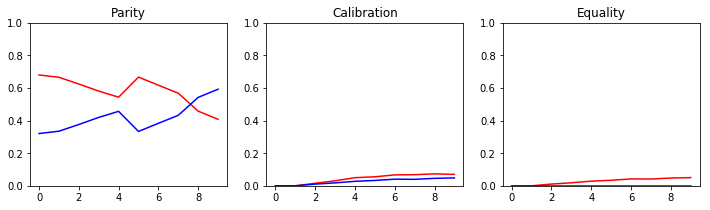

        trend0  trend1   cor  dist   sig
parity   -0.24    0.24 -1.00  0.22  0.00
cal       0.09    0.06  0.99  0.02  0.14
eq        0.06    0.00   NaN  0.03  0.00

colorblind
# protected items 13
# protected items 187


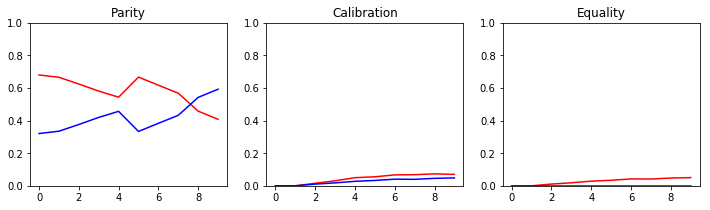

        trend0  trend1   cor  dist   sig
parity   -0.24    0.24 -1.00  0.22  0.00
cal       0.09    0.06  0.99  0.02  0.14
eq        0.06    0.00   NaN  0.03  0.00

feldman
# protected items 30
# protected items 170


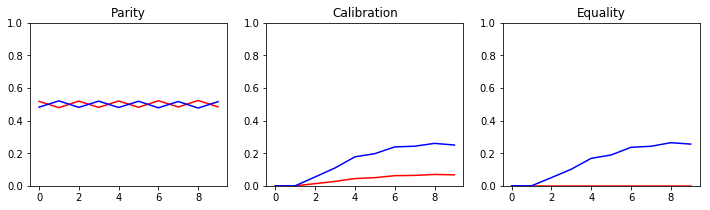

        trend0  trend1  cor  dist   sig
parity   -0.01    0.01 -1.0  0.04  0.83
cal       0.09    0.33  1.0  0.11  0.00
eq        0.00    0.34  NaN  0.15  0.00
fair 1
# protected items 15
# protected items 185


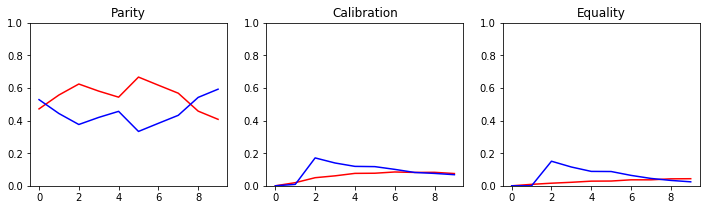

        trend0  trend1   cor  dist   sig
parity   -0.08    0.08 -1.00  0.16  0.01
cal       0.08    0.03  0.58  0.03  0.17
eq        0.05   -0.01  0.06  0.04  0.05
fair 2
# protected items 33
# protected items 167


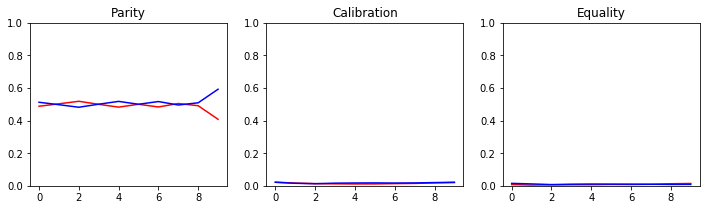

        trend0  trend1   cor  dist   sig
parity   -0.05    0.05 -1.00  0.03  0.09
cal      -0.00    0.00  0.71  0.00  0.12
eq        0.01   -0.00 -0.39  0.00  0.15
fair 3
# protected items 47
# protected items 153


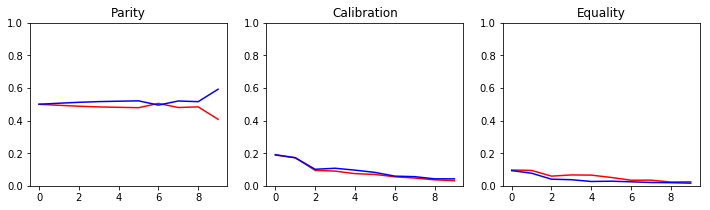

        trend0  trend1   cor  dist   sig
parity   -0.05    0.05 -1.00  0.04  0.00
cal      -0.16   -0.16  0.99  0.01  0.71
eq       -0.08   -0.07  0.91  0.02  0.17
fair 4
# protected items 66
# protected items 134


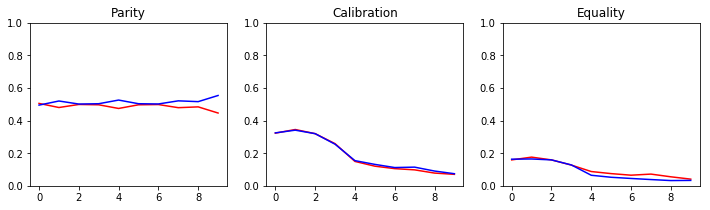

        trend0  trend1   cor  dist   sig
parity   -0.03    0.03 -1.00  0.03  0.00
cal      -0.35   -0.33  1.00  0.01  0.92
eq       -0.15   -0.18  0.99  0.01  0.58


In [64]:
print("German Credit k=200")
plotFA_IRRanks(ger2, w=100, s=10)

In [ ]:
def scale(data, col):
    data[col] = (data[col]-data[col].min()) / (data[col].max() - data[col].min())

In [29]:
# sliding_kendall_parity(german5['fair5'], window=100, step=10)[0]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.990,
 0.952,
 0.924,
 0.894,
 0.841,
 0.800,
 0.755,
 0.682,
 0.619,
 0.545,
 0.499,
 0.491,
 0.504,
 0.496,
 0.489,
 0.503,
 0.497,
 0.491,
 0.485,
 0.500,
 0.496,
 0.491,
 0.507,
 0.484,
 0.501,
 0.499,
 0.477,
 0.497,
 0.478,
 0.479,
 0.503,
 0.468,
 0.476]

In [48]:
# sliding_kendall_parity(german5['fair5'], window=100, step=10)[1]

Ther are only 149 items in the protected class (German Credit dataset)

So for a prefix of k=500: 

20% representation requires 100 items
30% requires 150
50% requires 250 items 
75% requires 375

This may be why we see the strange patterns in the parity plots for > 30% representation

German Credit k=500

Window: 100, Step: 10

baseline
# protected items 64
# protected items 436


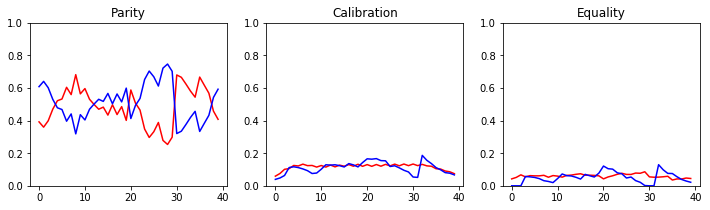

        trend0  trend1   cor  dist   sig
parity    0.11   -0.11 -1.00  0.19  0.32
cal       0.61    1.27  0.56  0.02  0.37
eq       -4.25    1.71 -0.12  0.03  0.12

colorblind
# protected items 64
# protected items 436


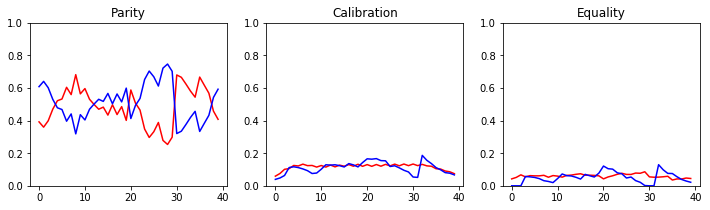

        trend0  trend1   cor  dist   sig
parity    0.11   -0.11 -1.00  0.19  0.32
cal       0.61    1.27  0.56  0.02  0.37
eq       -4.25    1.71 -0.12  0.03  0.12

feldman
# protected items 75
# protected items 425


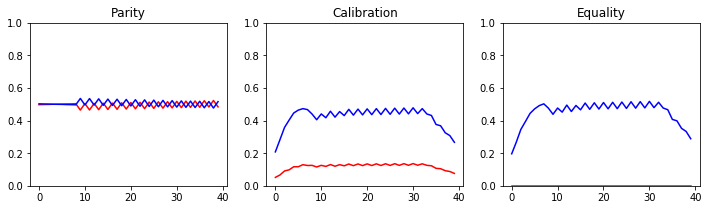

        trend0  trend1   cor  dist   sig
parity    1.34   -1.34 -1.00  0.03  0.01
cal       2.40    0.02  0.97  0.30  0.00
eq         NaN    0.48   NaN  0.45  0.00
fair 1
# protected items 64
# protected items 436


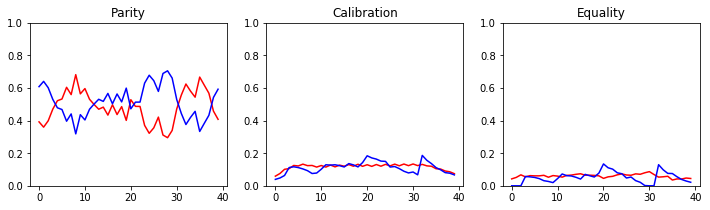

        trend0  trend1   cor  dist   sig
parity    0.03   -0.03 -1.00  0.16  0.13
cal       0.62    1.46  0.59  0.02  0.45
eq       -2.95    1.62 -0.28  0.03  0.13
fair 2
# protected items 89
# protected items 411


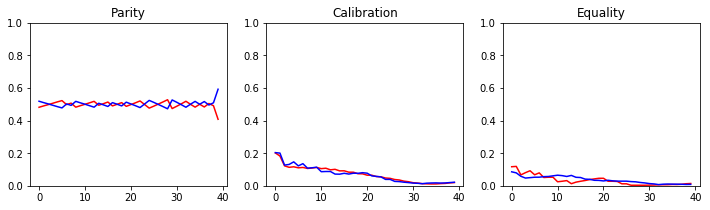

        trend0  trend1   cor  dist   sig
parity   -3.92    3.92 -1.00  0.03  0.25
cal      -5.85   -5.39  0.97  0.01  0.95
eq       -7.86  -12.70  0.75  0.02  0.57
fair 3
# protected items 130
# protected items 370


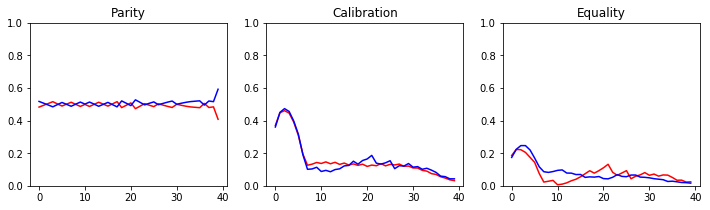

        trend0  trend1   cor  dist   sig
parity   -7.43    7.43 -1.00  0.02  0.00
cal      -2.04   -1.75  0.98  0.02  0.99
eq       -2.54   -3.85  0.77  0.03  0.85
fair 4
# protected items 149
# protected items 351


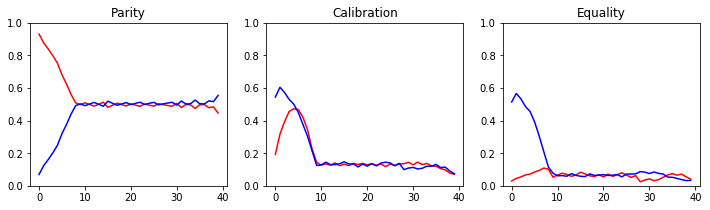

        trend0  trend1   cor  dist   sig
parity   -1.67    1.67 -1.00  0.12  0.00
cal      -1.80   -1.42  0.87  0.04  0.55
eq       -5.15   -1.31 -0.01  0.09  0.00


In [49]:
print("German Credit k=500")
plotFA_IRRanks(german5, w=100, s=10)

Compas Gender k=ALL

Window: 100, Step: 10
baseline


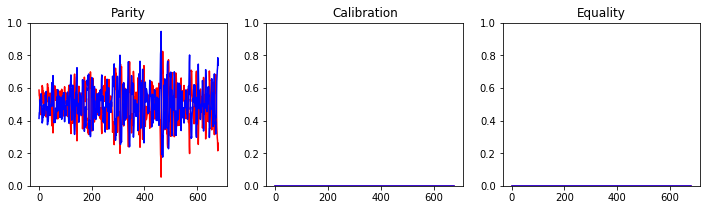

        trend0  trend1  cor  dist   sig
parity   -0.45    0.45 -1.0  0.17  0.45
cal        NaN     NaN  NaN  0.00   NaN
eq         NaN     NaN  NaN  0.00   NaN
colorblind


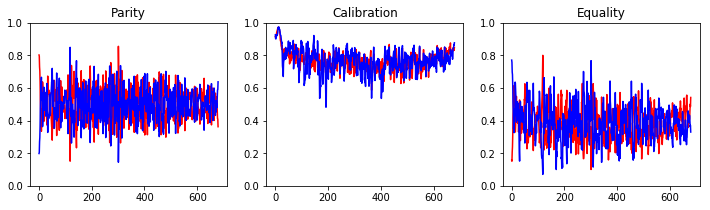

        trend0  trend1   cor  dist   sig
parity   -0.50    0.50 -1.00  0.15  0.38
cal      -4.14   -2.68  0.69  0.04  0.37
eq        0.02   -1.11 -0.77  0.15  0.18
feldman


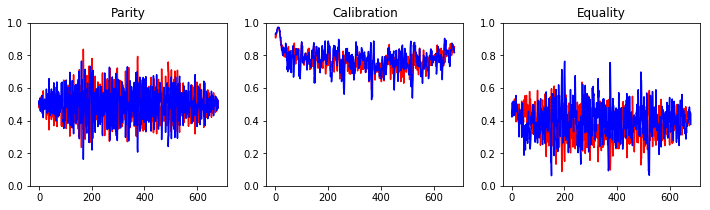

        trend0  trend1   cor  dist   sig
parity    0.12   -0.12 -1.00  0.14  0.80
cal      -4.45   -2.84  0.70  0.04  0.04
eq       -1.50   -0.31 -0.76  0.14  0.00
fair 2


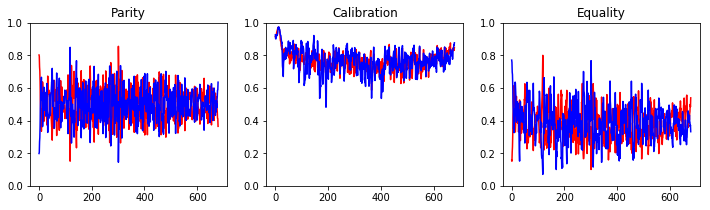

        trend0  trend1   cor  dist   sig
parity   -0.51    0.51 -1.00  0.15  0.38
cal      -4.14   -2.69  0.69  0.04  0.37
eq        0.02   -1.12 -0.77  0.15  0.19
fair 3


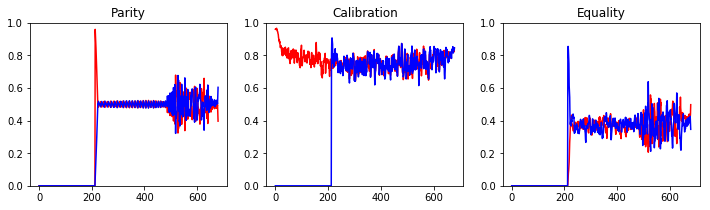

        trend0  trend1   cor  dist   sig
parity    3.20    3.44  0.91  0.04  0.64
cal      -4.63    2.30 -0.29  0.26  0.00
eq        4.52    4.02  0.85  0.05  0.48
fair 5


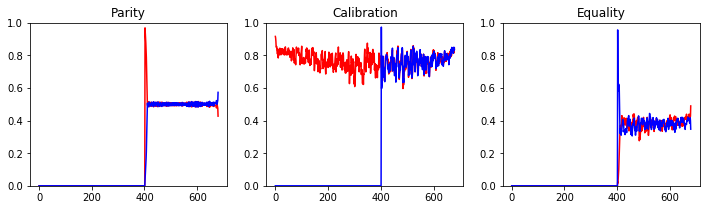

        trend0  trend1   cor  dist   sig
parity    3.28    3.49  0.95  0.01  0.58
cal      -4.13    2.28 -0.04  0.46  0.00
eq        4.55    4.33  0.94  0.02  0.70
fair 7


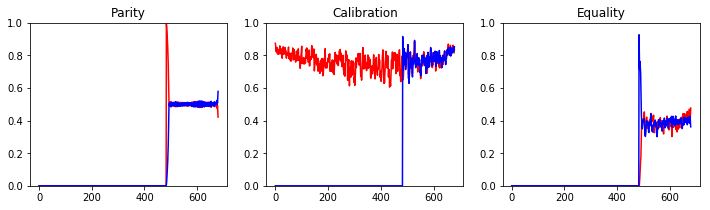

        trend0  trend1   cor  dist   sig
parity    3.20    3.50  0.93  0.01  0.46
cal      -2.42    2.22  0.16  0.54  0.00
eq        4.45    4.06  0.91  0.02  0.51


In [139]:
print("Compas Gender k=ALL")
plotFA_IRRanks(compas_gender, w=100, s=10)

compas_race k=ALL

Window: 100, Step: 10
baseline


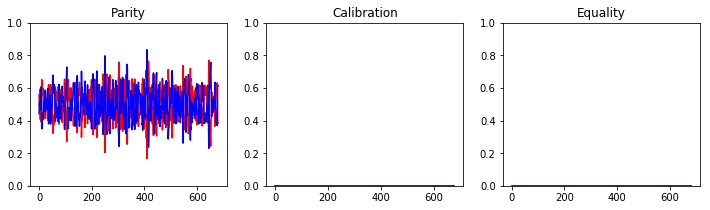

        trend0  trend1  cor  dist   sig
parity   -0.03    0.03 -1.0  0.15  0.56
cal        NaN     NaN  NaN  0.00   NaN
eq         NaN     NaN  NaN  0.00   NaN
colorblind


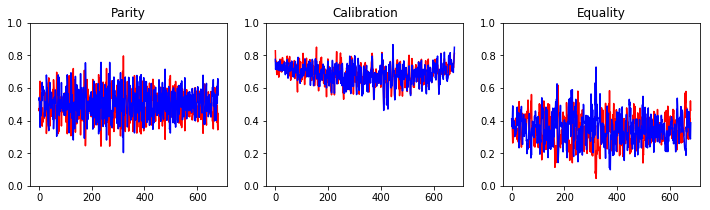

        trend0  trend1   cor  dist   sig
parity   -0.35    0.35 -1.00  0.13  0.04
cal      -1.63   -1.25  0.74  0.03  0.73
eq        0.16   -0.92 -0.77  0.12  0.20
feldman


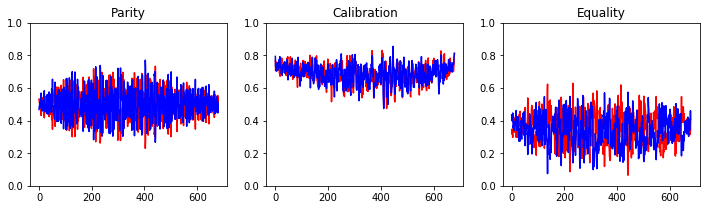

        trend0  trend1  cor  dist   sig
parity    0.05   -0.05 -1.0  0.13  0.91
cal      -1.50   -1.51  0.7  0.04  0.77
eq       -0.65   -0.13 -0.8  0.13  0.04
fair 2


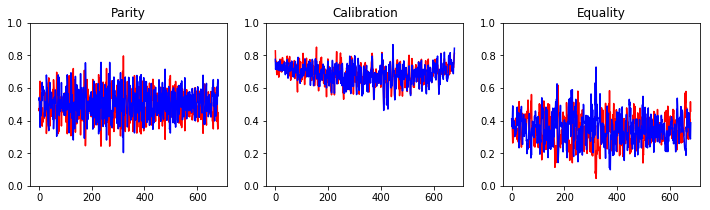

        trend0  trend1   cor  dist   sig
parity   -0.34    0.34 -1.00  0.13  0.04
cal      -1.63   -1.28  0.74  0.03  0.72
eq        0.16   -0.92 -0.77  0.12  0.20
fair 3


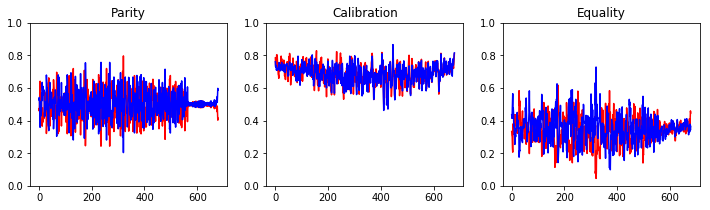

        trend0  trend1   cor  dist   sig
parity   -0.19    0.19 -1.00  0.12  0.06
cal      -2.05   -1.52  0.76  0.03  0.71
eq        0.34   -1.34 -0.75  0.11  0.00
fair 5


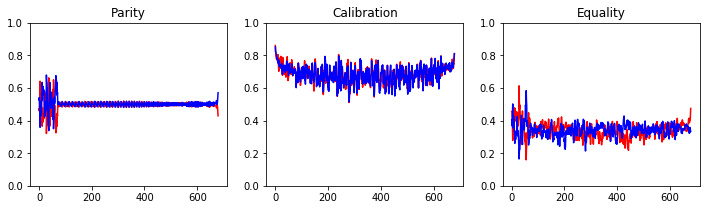

        trend0  trend1   cor  dist   sig
parity    2.23   -2.23 -1.00  0.03  0.01
cal      -0.83   -1.00  0.93  0.01  0.82
eq       -2.87    1.92 -0.26  0.05  0.98
fair 7


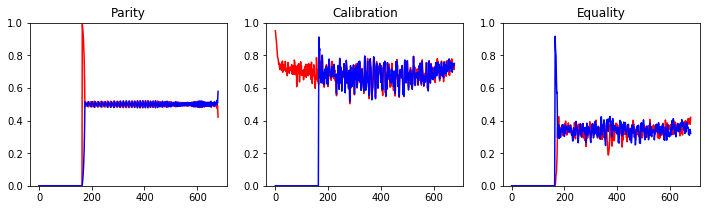

        trend0  trend1   cor  dist   sig
parity    3.12    3.50  0.91  0.02  0.40
cal      -2.54    2.51 -0.13  0.18  0.00
eq        5.13    4.22  0.85  0.03  0.24


In [140]:
print("compas_race k=ALL")
plotFA_IRRanks(compas_race, w=100, s=10)